# Publication/Presentation figures

This notebook is used to generate pretty figures used in presentations and publications.

In [267]:
sys.path.append('../scripts/')
from utilities import *

import pandas as pd
from os.path import join
import pickle
import pdb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

sns.set()
sns.set_context('poster',font_scale=2)

idx = pd.IndexSlice

home_dir = '/Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments'
s = Settings(home_dir)

save_fpath_berk = join(s.berk.home_dir,'session_level_environmental_data.csv')
save_fpath_bus = join(s.bus.home_dir,'session_level_environmental_data.csv')

int_data_dir = '../../data/int'

In [268]:
timing_df_berk = get_timing_df_berk(s)
timing_df_bus = get_timing_df_bus(s)
with open(join(int_data_dir,'sensor_data_berk.pickle'),'rb') as f:
    dfs_berk = pickle.load(f)
with open(join(int_data_dir,'sensor_data_bus.pickle'),'rb') as f:
    dfs_bus = pickle.load(f)
    
colors = {'California':{'control':'b',
                   'treatment':'r'},
     'Nairobi':{'control':'b',
               'treatment':'r'}}

def interpolate_within(x):
    res = x.copy()
    if np.isnan(x[1]):
        length = x.last_valid_index()
        res[:length+1] = res[:length+1].interpolate()
    return res

/Users/ianbolliger/anaconda/envs/cooking_people/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ianbolliger/anaconda/envs/cooking_people/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [269]:
## Get dataframes of T timeseries by session

ts_dfs = {}

in_dfs = {'California':dfs_berk['indoor'],
         'Nairobi':dfs_bus['indoor']}
timing_dfs = {'California':timing_df_berk,
             'Nairobi':timing_df_bus}
site_settings = {'California':s.berk,
                'Nairobi':s.bus}
for site in ['California','Nairobi']:
    ts_dfs[site] = {}
    timing_df = timing_dfs[site]
    
    for grp_ix,grp in enumerate(['control','treatment']):
        grp_df = timing_df[timing_df['Treatment group']==grp_ix]
        ts_dfs[site][grp] = {}
        
        # one dataframe for each sensor location
        loc_dfs = []
        for loc in site_settings[site].sens_locs + [str(i) for i in range(1,7)]:
            tmp_df = in_dfs[site][grp][loc].reset_index()

            # assign to session
            tmp_df['sess'] = pd.cut(tmp_df['time'],bins=grp_df.index)

            # keep only measurements during sessions
            tmp_df = tmp_df[tmp_df['sess'].notnull()]

            # get interval for each observation
            tmp_df['t_ix_sess'] = tmp_df.groupby('sess').cumcount()
            
            # adjust for when we had 5 min intervals in berkeley
            if loc in site_settings[site].sens_locs:
                tmp_df['t_ix_sess'] = tmp_df['t_ix_sess'].where(tmp_df['time'] >= s.berk.sensor_swap_date, tmp_df['t_ix_sess']*5)
            
            # pivot to wide table
            T_by_sess = tmp_df.pivot(index='sess', columns='t_ix_sess', values='T').T
            loc_dfs.append(T_by_sess)

        site_df = (loc_dfs[0]+loc_dfs[1])/2
        site_df = site_df.loc[:,site_df.notnull().any()]
        ts_dfs[site][grp]['room_avg'] = site_df
        for i in range(1,7):
            ts_dfs[site][grp]['p{}'.format(i)] = loc_dfs[i+1]
        

## Plots

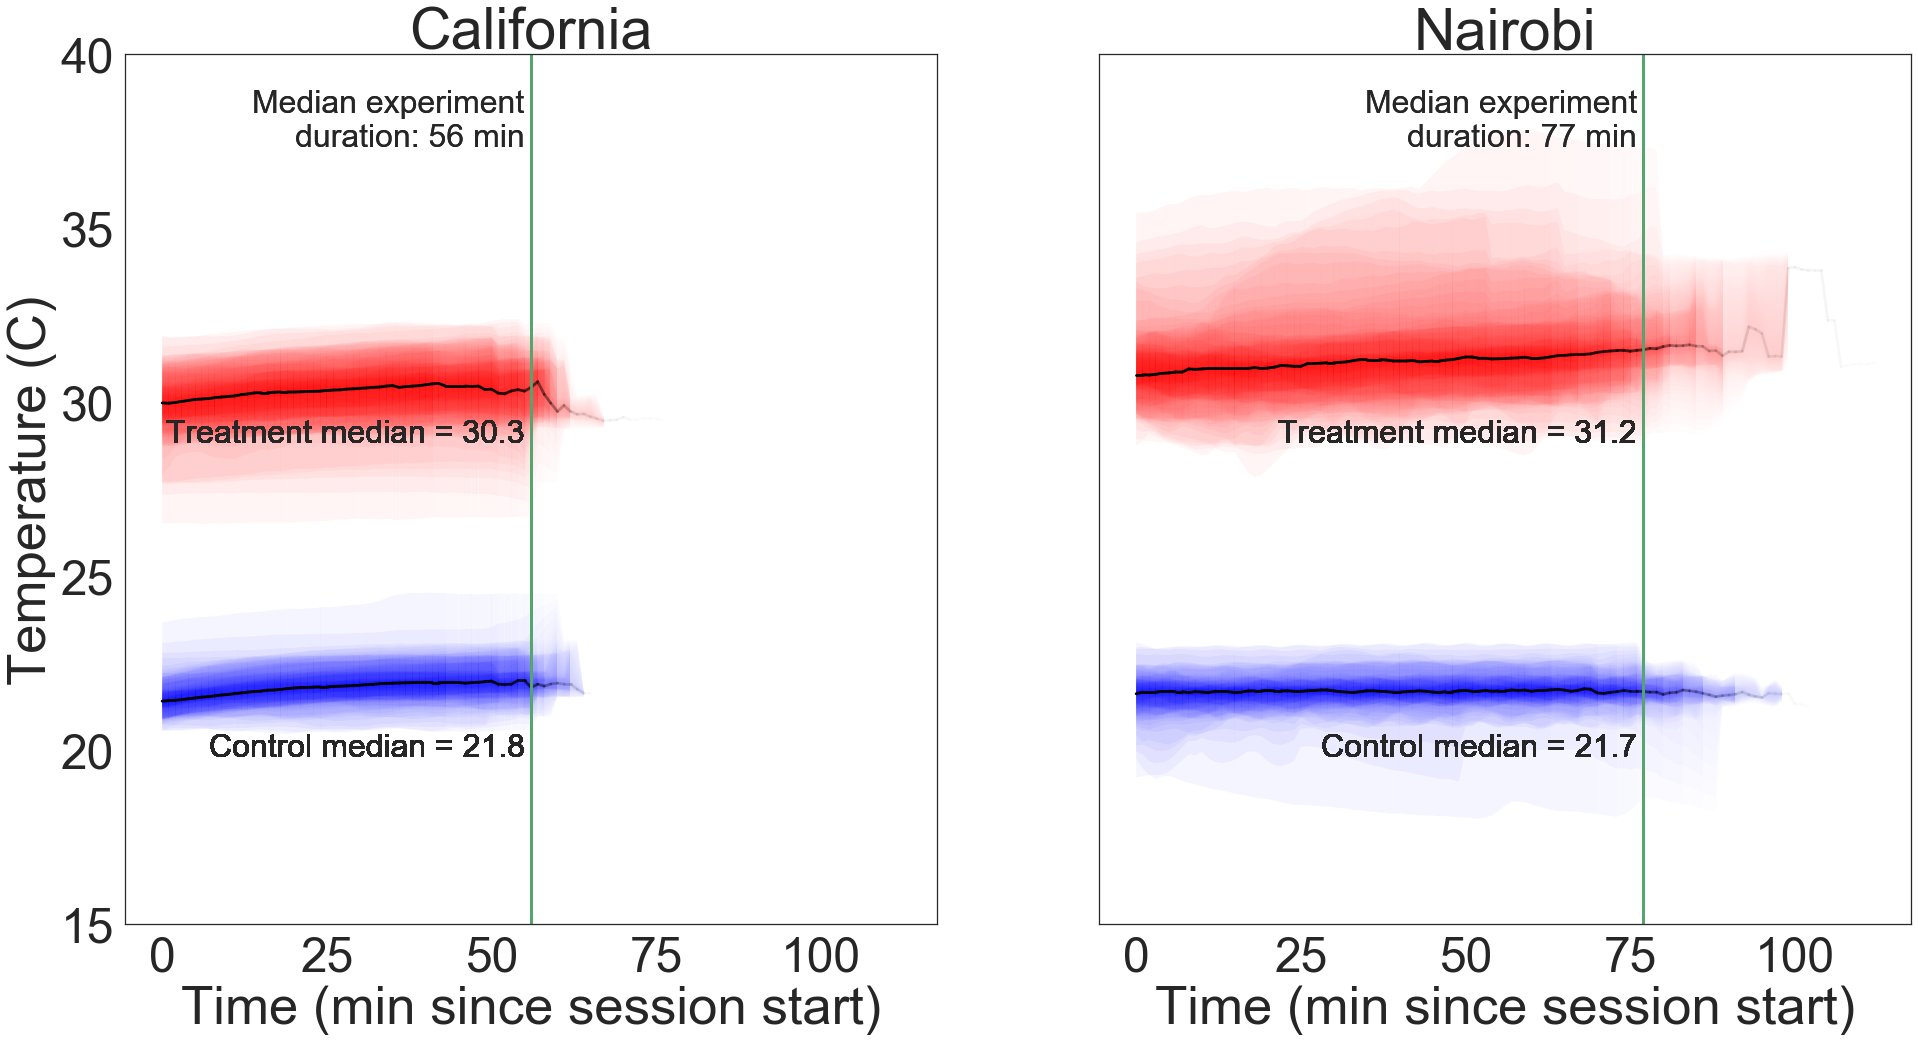

In [13]:
sns.set_context('poster',font_scale=3,rc={'font.size':32})
style = 'white'
with sns.axes_style(style):
    fig,axs = plt.subplots(1,2, figsize = (32,16),sharex=True,sharey=True)

    axs[0].set_ylabel('Temperature (C)')
    for six,site in enumerate(['California','Nairobi']):
        lines = []
        ax = axs[six]
        ax.set_title(site)
        ax.set_xlabel('Time (min since session start)')
        for grp in ['control','treatment']:
            if grp == 'treatment':
                lab_ht = 29.5
            else:
                lab_ht = 20.5
            this_df = ts_dfs[site][grp]['room_avg'].copy()
            length = this_df.apply(lambda x: x.last_valid_index())
            this_df = this_df.apply(interpolate_within)
            med = this_df.quantile(q=.5,axis=1)
            count = this_df.count(axis=1)
            mean_of_med = (med*count).sum()/count.sum()
            med_length = length.median()
            for j in range(count.index.shape[0]-1):
                txt = '{} median = {:.1f}'.format(
                    grp.title(),mean_of_med)
                line, = ax.plot(med.index[j:j+2],med[j:j+2], color = 'k', 
                    label = txt, alpha = count[j]/count.max())
                ax.text(med_length-1,lab_ht, txt, verticalalignment='top',
                       horizontalalignment='right')
                if j == count.index.shape[0]-2:
                    lines.append(line)
            ax.plot([med_length,med_length],[0, 40])
            ax.text(med_length-1,39,'Median experiment\nduration: {:d} min'.format(int(med_length)),
                    verticalalignment='top',horizontalalignment='right')
            for i in np.arange(0,.5,.01):
                this_quantile_low = this_df.quantile(q=i,axis=1)
                this_quantile_high = this_df.quantile(q=1-i,axis=1)
                for j in range(count.index.shape[0]-1):
                    poly = ax.fill_between([this_quantile_low.index[j],this_quantile_low.index[j+1]],
                                           this_quantile_low.iloc[j:j+2], this_quantile_high.iloc[j:j+2],
                                           alpha=.0005*count.iloc[j],color = colors[site][grp])
                    poly.set_edgecolor('none')
            ax.set_ylim((15,40))

fig.savefig('../../results/figures/main_experiment/watercolor_temps_{}.png'.format(style))

## Module Timing Table

In [270]:
from glob import glob
from os.path import basename
from datetime import timedelta

In [340]:
modules = ['production','dictator','risk_game','t_preference','trust','public_goods',
          'ravens','joy_O_D','survey','charity']
loc_dirs = {'California':join(home_dir,'Xlab data','Main experiment data','Modules'),
           'Nairobi':join(home_dir,'Busara data','Main experiment data','Modules')}
locs = ['California','Nairobi']
txs = ['control','treatment']

tzs = {'California':'US/Pacific',
      'Nairobi':'Africa/Nairobi'}

def ts_parser(d, tz):
    return pd.to_datetime(d, unit='s').tz_localize('UTC').tz_convert(tz).tz_localize(None)

def get_mean_temp(row,temps_df,st_time,loc,tx):
    st = int((row['start_time'] - st_time).total_seconds() / 60)
    end = int((row['end_time'] - st_time).total_seconds() / 60)
    
    if st < 0:
        ## There are many cases in Nairobi where the start time for production
        ## module occurs before the recorded starting time in the experiment_timing.csv
        ## file. IB is investigating this w/ Ray but the hunch is that the Busara team
        ## opened the experiment to the introduction page prior to participants entering room.
        ## This is b/c the time spent on the intro page is often very long. So we are assuming
        ## the start times are 0 for these cases.
#         print('For session {},{},{}: Recorded start time occurred {} min after module interaction. Dropping...'.format(
#             loc,tx,st_time,-st))
        st = 0
    return pd.Series([temps_df[st:end].mean(),st,end], index = ['temps','st','end'])


module_temps = {'California':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)},
               'Nairobi':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)}}
start_times = {'California':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)},
               'Nairobi':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)}}
end_times = {'California':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)},
               'Nairobi':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)}}


for loc in locs:
    date_dirs = glob(join(loc_dirs[loc],'*'))
    for d in date_dirs:
        sessions = glob(join(d,'*'))
        for s in sessions:
            sess = basename(s).split()
            if sess[2] == 'C':
                tx = 'control'
            elif sess[2] == 'T':
                tx = 'treatment'
            else:
                raise ValueError

            ts_fpath = glob(join(s,'TimeSpent*'))
            if len(ts_fpath):
                ts_fpath = ts_fpath[0]
            else:
                print('No module time data: {}'.format(s))
                continue
            this_df = pd.read_csv(ts_fpath,parse_dates = ['time_stamp'],
                                 date_parser = lambda x: ts_parser(x,tzs[loc]))
            this_df = this_df.loc[this_df['app_name'].isin(modules),['app_name','participant__id_in_session','time_stamp',
                                              'seconds_on_page']]
            this_df = this_df.sort_values(['participant__id_in_session','app_name'])
            midtime = this_df.sort_values('time_stamp').iloc[int(this_df.shape[0]/2),2]
            groups = this_df.groupby(['participant__id_in_session','app_name'])
            
            # start times
            st = groups.first()
            # For production, take starting point as "end of intro slide"
            # b/c this comes first and in busara they navigated to this page
            # before the participants entered
            page_start = st['time_stamp'] - st['seconds_on_page'].apply(
                        lambda x: timedelta(seconds=x))
            st = page_start.where(st.index.get_level_values(1) != 'production',
                          st['time_stamp'])
#             st = st['time_stamp'] - st['seconds_on_page'].apply(lambda x: timedelta(seconds=x))
            st.name = 'start_time'
            
            # end times
            end = groups.last()['time_stamp']
            end.name = 'end_time'

            # get times for temp data
            try:
                this_temps = ts_dfs[loc][tx]['room_avg'][midtime].interpolate()
                sess_st_time = this_temps.name.left
            except:
                continue
            
            this_times = pd.DataFrame([st,end]).T
            vals = this_times.apply(lambda x: get_mean_temp(x,this_temps,sess_st_time,loc,tx),axis=1)
            vals = vals[vals['temps'].notnull()]

            # average accross participants
            vals = vals.groupby(level=1).median()
            module_temps[loc][tx][this_temps.name] = vals['temps']
            start_times[loc][tx][this_temps.name] = vals['st']
            end_times[loc][tx][this_temps.name] = vals['end']

No module time data: /Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments/Xlab data/Main experiment data/Modules/9-25/Session 2 T


In [341]:
idx = pd.IndexSlice
ix = pd.MultiIndex.from_product([['California','Nairobi'],['control','treatment'],modules],
                               names=['location','group','module'])
df = pd.DataFrame(index=ix,columns = ['st_time','end_time','mean_temp'])
for loc in locs:
    for tx in txs:
        this_df = pd.DataFrame({'st_time':start_times[loc][tx].median(axis=1),
                                               'end_time':end_times[loc][tx].median(axis=1),
                                               'mean_temp':module_temps[loc][tx].median(axis=1)})
        this_df.index = pd.MultiIndex.from_product([[loc],
                                                    [tx],list(start_times[loc][tx].index)],
                                                   names=['location','group','module'])
        df.loc[idx[loc,tx,:],:] = this_df

In [342]:
df

st_time end_time mean_temp
location   group     module                                 
California control   production     20.75       24    21.785
                     dictator          24       26     21.81
                     risk_game         26       29   21.8296
                     t_preference      29       33   21.8807
                     trust             33       37   21.8921
                     public_goods      37       40    21.923
                     ravens            40       45    21.941
                     joy_O_D           45       48   21.9392
                     survey            48    52.75   21.9448
                     charity        52.75       55   21.9685
           treatment production        21     24.5   30.3062
                     dictator        24.5       26    30.332
                     risk_game         26       30   30.3498
                     t_preference      30       34   30.4016
                     trust             34       38   30.4864
                     public_goods      38       41   30.5529
                     ravens            41       46   30.6514
                     joy_O_D           46       49   30.7019
                     survey            49       54   30.6681
                     charity           54       56   30.6441
Nairobi    control   production        23       29   21.7129
                     dictator          29     31.5   21.7129
                     risk_game       31.5       36   21.7033
                     t_preference      36       41   21.6725
                     trust             41       46   21.6942
                     public_goods      46     49.5   21.6845
                     ravens          49.5       61   21.6637
                     joy_O_D           61     64.5   21.6686
                     survey          64.5     70.5   21.7075
                     charity           70       74   21.7313
           treatment production        22       28   31.0011
                     dictator        27.5       30   31.0793
                     risk_game         30       34   31.1322
                     t_preference      34       40   31.1717
                     trust             40       45   31.2093
                     public_goods      45       51   31.2853
                     ravens            51       62   31.3193
                     joy_O_D           62       65   31.3495
                     survey            65     71.5   31.4002
                     charity         71.5     75.5   31.4673

In [343]:
df.to_csv('/Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments/Analysis/Tables/module_level_temps.csv')